# ELEN 644: CV1
## Homework 2

### Problem 1

Refer to homework report 

### Imports 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth 
import cv2
from tensorflow.keras import datasets
from tensorflow.keras.datasets import cifar10
%matplotlib inline

### Problem 2: Lucas Kanade Solution 

In [20]:
def lucas_kanade(video, winSize=(15,15), maxLevel=2):
    """ 
    Function that applies the Lucas Kanade Method for optical flow

    video: video to apply Lucas Kanade method. Video should be in mp4 format 
    winSize: Window size to be applied. Passed as a tuple 
    maxLevel:  
        0-based maximal pyramid level number; if set to 0, pyramids are not used (single level), 
        if set to 1, two levels are used, and so on; 
        if pyramids are passed to input then algorithm will use as many levels as pyramids have but no more than maxLevel.



    """



    cap = cv2.VideoCapture(video)

    # params for ShiTomasi corner detection
    feature_params = dict(  maxCorners = 100,
                            qualityLevel = 0.3,
                            minDistance = 7,
                            blockSize = 7 )

    # Parameters for lucas kanade optical flow
    lk_params = dict( winSize  = winSize,
                      maxLevel = maxLevel,
                      criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # Create some random colors
    color = np.random.randint(0,255,(100,3))

    # Take first frame and find corners in it
    ret, old_frame = cap.read()
    old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
    p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

    # Create a mask image for drawing purposes
    mask = np.zeros_like(old_frame)

    while(1):
        ret,frame = cap.read()
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # calculate optical flow
        p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

        # Select good points
        good_new = p1[st==1]
        good_old = p0[st==1]

        # draw the tracks
        for i,(new,old) in enumerate(zip(good_new,good_old)):
            a,b = new.ravel()
            c,d = old.ravel()
            a = int(a)
            b = int(b)
            c = int(c)
            d = int(d)
            mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
            frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
        img = cv2.add(frame,mask)

        cv2.imshow('frame',img)
        k = cv2.waitKey(30) & 0xff
        if k == 27:
            break

        # Now update the previous frame and previous points
        old_gray = frame_gray.copy()
        p0 = good_new.reshape(-1,1,2)

    cv2.destroyAllWindows()
    cv2.waitKey(1)
    cap.release()

    return  

In [22]:
video1 = "british_highway_traffic.mp4"
video2 = "dhaka_traffic.mp4"
video3 = "road_trafifc.mp4"
video4 = "traffic_video.avi"
video5 = "traffic_detection.mp4"

lucas_kanade(video4, winSize=(15,15), maxLevel=2)

### Problem 3: K-Means & Mean-Shift 

#### Loading CIFAR-10 images

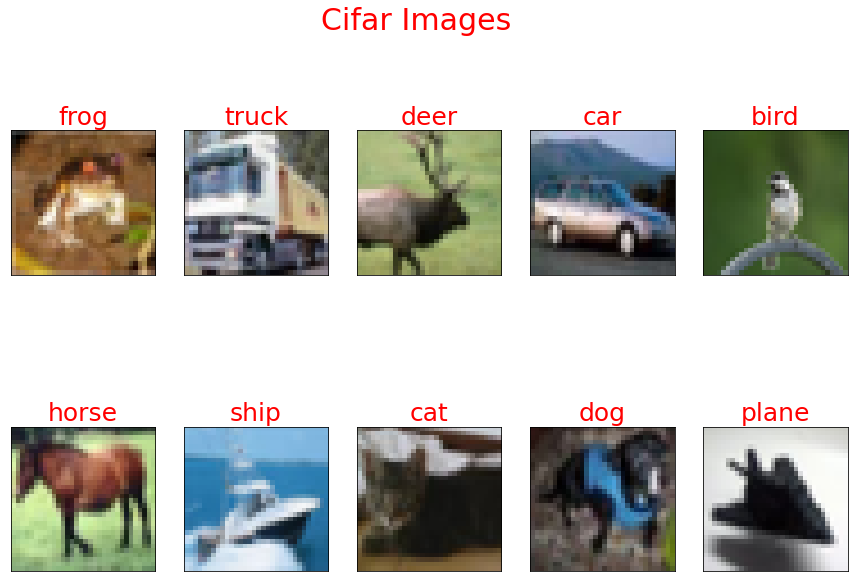

In [2]:
# Obtaining CIFAR 10 images 

# Downloading CIFAR 10 via Tensorflow 
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Frog 
frog = x_train[0]
#plt.imshow(frog)

# Truck 
truck = x_train[1]
#plt.imshow(truck)

# Deer
deer = x_train[34]
#plt.imshow(deer)

# Automobile 
car = x_train[4]
#plt.imshow(car)

# Bird 
bird = x_train[54]
#plt.imshow(bird)

# Horse 
horse = x_train[7]
#plt.imshow(horse)

# Ship 
ship = x_train[8]
#plt.imshow(ship)

# Cat
cat = x_train[9]
#plt.imshow(cat)

# Dog 
dog = x_train[27]
#plt.imshow(dog)

# Plane 
plane = x_train[29]
#plt.imshow(plane)

img = [frog, truck, deer, car, bird, horse, ship, cat, dog, plane]
titles = ['frog', 'truck', 'deer', 'car', 'bird', 'horse', 'ship', 'cat', 'dog', 'plane']


def plot_ls(image_ls,title):
    title = str(title)

    plt.figure(figsize=(15,10))
    for i in range(len(image_ls)):
        plt.subplot(2,5,i+1)
        plt.imshow(image_ls[i],cmap='gray')
        plt.title(titles[i],color='red',fontsize=25)
        plt.xticks([])
        plt.yticks([])

    plt.suptitle(t=title, color='red', fontsize=30)
    plt.show()

plot_ls(img,"Cifar Images")

#### k-Means 

In [4]:
def im_seg_kmeans(image, k_cluster=3):

    """ 
    image     : input image for segmentation
    k_clusters: k value for kmeans algorithm 
    """
    
    # Creating a copt of the image and normalizing 
    img = np.copy(image)
    img = img.astype('float32') / 255.0


    # Reshaping image array into a 2D array
    # Features used for k-means will be the RGB
    rows, cols, channels = img.shape
    pixels = img.reshape(-1, channels)

    # Applying K-means to obtain image cluster 
    kmeans = KMeans(n_clusters=k_cluster, random_state=0).fit(pixels)
    clusters = kmeans.cluster_centers_[kmeans.labels_]

    # Reshaping back to the original image shape 
    segmented = clusters.reshape(rows,cols,channels)

    return segmented


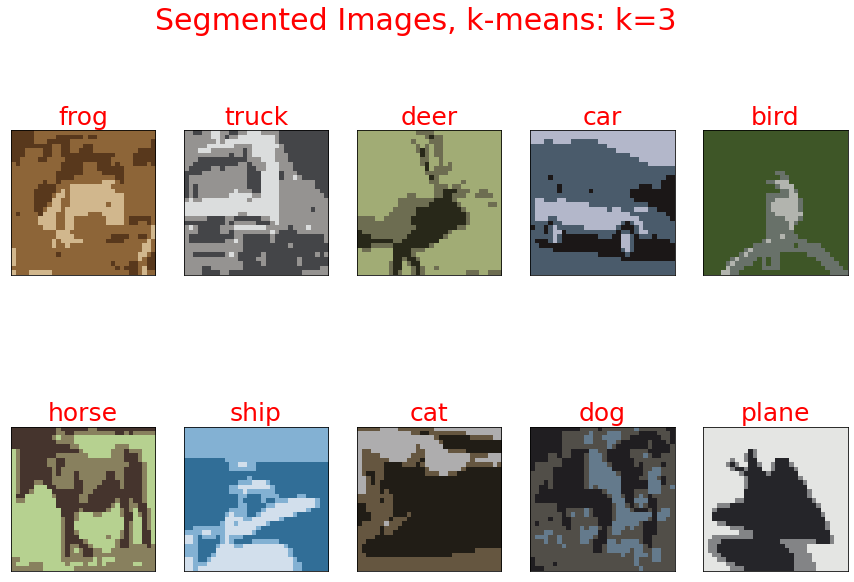

In [5]:
segmented_ls = []
k = 3 

for i in range(len(img)):
    seg_im = im_seg_kmeans(img[i])
    segmented_ls.append(seg_im)

title = "Segmented Images, k-means: k=" + str(k)
plot_ls(segmented_ls, title)

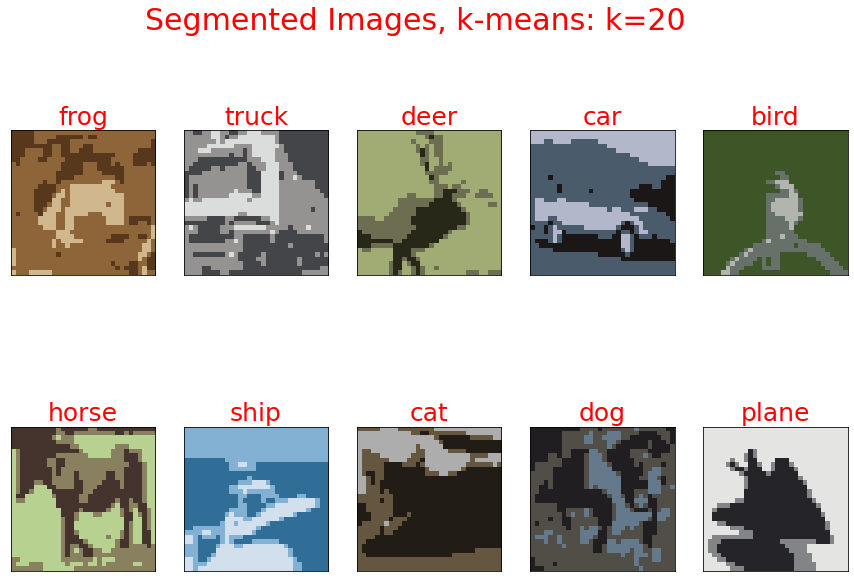

In [7]:
segmented_ls = []
k = 20

for i in range(len(img)):
    seg_im = im_seg_kmeans(img[i])
    segmented_ls.append(seg_im)

title = "Segmented Images, k-means: k=" + str(k)
plot_ls(segmented_ls, title)

#### Mean-shift 

In [8]:
def im_seg_meanshift(image, bandwidth=3, est_bandwidth=False):
    """ 
    image: input image for segmentation
    bandwidth: Radius of window size used to compute the mean 
    est_bandwidth: if set to true, the function will estimate a bandwidth to be used
    """


    # Creating a copy of the image and normalizing 
    img = np.copy(image)
    #img = img.astype('float32') / 255.0
    img = img / 255

    # Reshaping image array into a 2D array
    # Features used for mean shifted will be the RGB
    rows, cols, channels = img.shape
    pixels = img.reshape(-1, channels)

    # Estimate bandwidth can be used to estimate the radius of the 
    # window to compute the mean
    if est_bandwidth == True:
        bandwidth = estimate_bandwidth(pixels)
  

    mean_shifted = MeanShift(bandwidth=bandwidth).fit(pixels)
    clusters = mean_shifted.cluster_centers_[mean_shifted.labels_]

    clusters = clusters.reshape(rows,cols,channels)


    # Reshaping back to the original image shape 
    segmented = clusters.reshape(rows,cols,channels)
    # plt.imshow(segmented,cmap='gray')
    # plt.show()

    return segmented

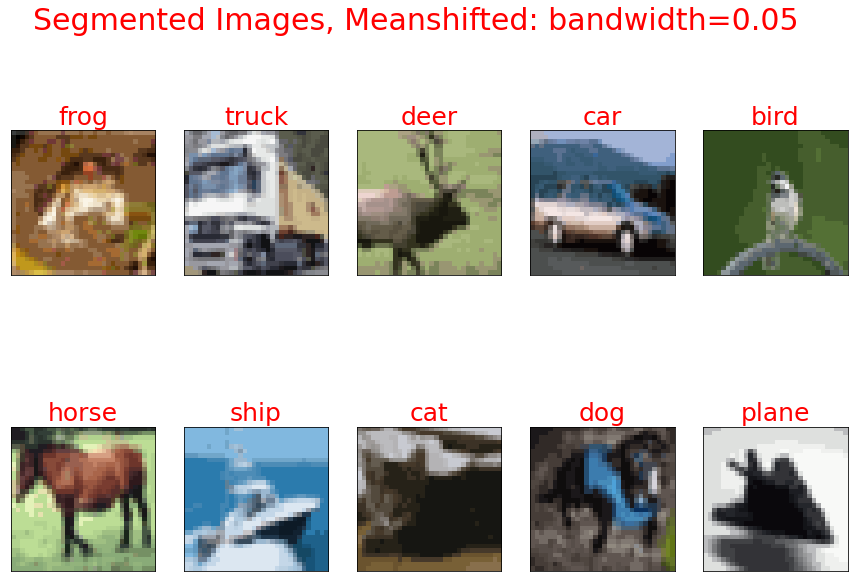

In [9]:
segmented_ls = []
bandwidth = 0.05
for i in range(len(img)):
    seg_im = im_seg_meanshift(img[i],bandwidth=bandwidth,est_bandwidth=False)
    segmented_ls.append(seg_im)

title = "Segmented Images, Meanshifted: bandwidth=" + str(bandwidth)
plot_ls(segmented_ls, title)

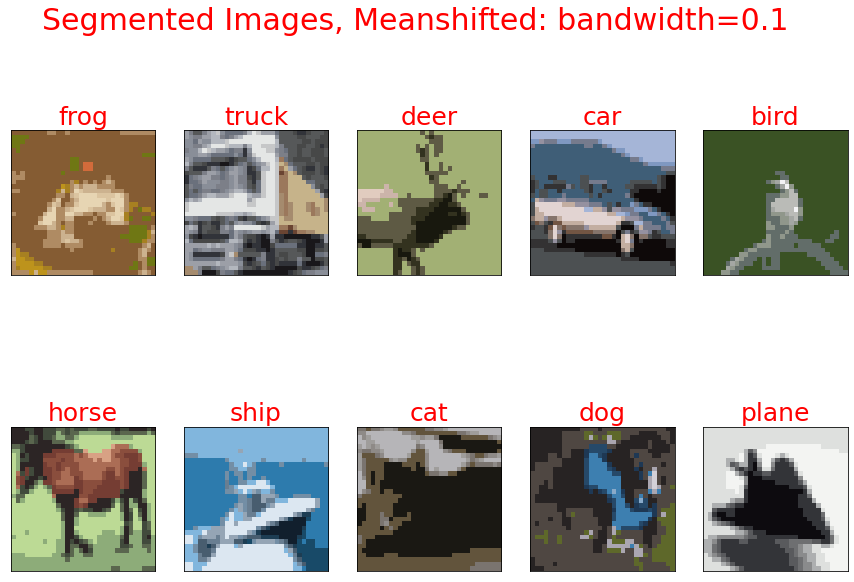

In [11]:
segmented_ls = []
bandwidth = 0.1
for i in range(len(img)):
    seg_im = im_seg_meanshift(img[i],bandwidth=bandwidth,est_bandwidth=False)
    segmented_ls.append(seg_im)

title = "Segmented Images, Meanshifted: bandwidth=" + str(bandwidth)
plot_ls(segmented_ls, title)